## Kaggle Digit Recognizer

`kaggle competitions download -c digit-recognizer`

In [125]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('kg-data/train.csv', sep=',')
train.shape

(42000, 785)

In [173]:
X = train.iloc[:, 1:]
Y = train.iloc[:, 0]
Y_oh = pd.get_dummies(Y)

input_len = X.shape[1]

test_size = 0.1
X_train, X_test = train_test_split(X, test_size=test_size, shuffle=False)
Y_train, Y_test = train_test_split(Y, test_size=test_size, shuffle=False)
Y_train_oh, Y_test_oh = train_test_split(Y_oh, test_size=test_size, shuffle=False)

X_train = X_train.values
Y_train_oh = Y_train_oh.values

X_test = X_test.values
Y_test_oh = Y_test_oh.values

In [174]:
# reshape

X_train_len = len(X_train)
X_train = X_train.reshape((X_train_len, 28, 28, 1))

X_test_len = len(X_test)
X_test = X_test.reshape((X_test_len, 28, 28, 1))

## Model

In [59]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import load_model

In [95]:
def DigitRec_v1():
    pixel_values = Input(shape=(28, 28, 1, ), dtype='float32')
    X = Flatten()(pixel_values)
    X = Dense(20, activation='relu')(X)
    X = Dense(20, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=pixel_values, outputs=X)
    return model

In [80]:
def DigitRec_LeNet5():
    pixel_values = Input(shape=(28, 28, 1, ), dtype='float32')
    X = Conv2D(6, (5, 5), padding='same', activation='tanh')(pixel_values)
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Conv2D(16, (5, 5), activation='tanh')(X)
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Conv2D(120, (5, 5), activation='tanh')(X)
    X = Flatten()(X)
    X = Dense(84, activation='tanh')(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=pixel_values, outputs=X)
    return model

In [168]:
del model

In [169]:
model = DigitRec_LeNet5()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_28 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_29 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_8 (Flatten)          (None, 120)               0         
__________

In [170]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [171]:
model.fit(X_train, Y_train_oh, epochs=15, batch_size=64, shuffle=True)

Epoch 1/15
37800/37800 [==============================] - 10s 261us/step - loss: 0.2279 - acc: 0.9332
Epoch 2/15
37800/37800 [==============================] - 9s 248us/step - loss: 0.0827 - acc: 0.9748
Epoch 3/15
37800/37800 [==============================] - 9s 244us/step - loss: 0.0586 - acc: 0.9824
Epoch 4/15
37800/37800 [==============================] - 9s 242us/step - loss: 0.0454 - acc: 0.9862
Epoch 5/15
37800/37800 [==============================] - 9s 248us/step - loss: 0.0395 - acc: 0.9870
Epoch 6/15
37800/37800 [==============================] - 9s 243us/step - loss: 0.0305 - acc: 0.9902
Epoch 7/15
37800/37800 [==============================] - 10s 256us/step - loss: 0.0283 - acc: 0.9906
Epoch 8/15
37800/37800 [==============================] - 10s 256us/step - loss: 0.0224 - acc: 0.9929
Epoch 9/15
37800/37800 [==============================] - 9s 243us/step - loss: 0.0191 - acc: 0.9942
Epoch 10/15
37800/37800 [==============================] - 9s 248us/step - loss: 0.0161 

In [175]:
loss, acc = model.evaluate(X_test, Y_test_oh)
print("Test accuracy = ", acc)

4200/4200 [==============================] - 1s 187us/step
Test accuracy =  0.9842857142857143


## Predict

In [176]:
import matplotlib.pyplot as plt

In [177]:
test = pd.read_csv('kg-data/test.csv', sep=',')
test.shape

X_test = test.values
X_test_len = len(X_test)
X_test = X_test.reshape((X_test_len, 28, 28, 1))

X_test.shape

(28000, 28, 28, 1)

In [178]:
pred = model.predict(X_test)

In [179]:
labels = []
for i in range(len(X_test)):
    num = np.argmax(pred[i])
    labels.append(num)

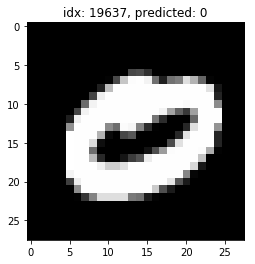

In [180]:
idx = np.random.randint(len(X_test))
pixels = X_test[idx].reshape((28, 28))

plt.title('idx: ' + str(idx) + ', predicted: ' + str(labels[idx]))
plt.imshow(pixels, cmap='gray')
plt.show()

In [181]:
pred_df = pd.DataFrame(columns=['ImageId', 'Label'])
for i in range(len(labels)):
    pred_df.loc[i] = (i+1, labels[i])

In [182]:
pred_df[0:10]

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [184]:
pred_df.to_csv('kg-data/submission.csv', sep=',', index=False)